In [ ]:
# 3. ADVANCED BUDGET OPTIMIZATION VISUALIZATIONS
fig, axes = plt.subplots(2, 3, figsize=(22, 14))
fig.suptitle('Advanced Budget Optimization Analysis', fontsize=18, fontweight='bold')

# 3.1 Risk-Return Analysis (Volatility vs ROAS)
ax1 = axes[0, 0]

for i, client in enumerate(clients):
    for platform in ['Meta', 'TikTok']:
        # Get weekly data for this client-platform
        client_platform_data = weekly_data[
            (weekly_data['client_id'] == client) & 
            (weekly_data['platform'] == platform)
        ]
        
        if len(client_platform_data) > 1:
            avg_roas = client_platform_data['ROAS'].mean()
            roas_std = client_platform_data['ROAS'].std()
            total_spend = client_platform_data['spend'].sum()
            
            color = colors[platform]
            marker = 'o' if platform == 'Meta' else '^'
            
            ax1.scatter(roas_std, avg_roas, s=total_spend/5000, 
                       color=color, marker=marker, alpha=0.7,
                       label=f'{platform}' if i == 0 else '')
            
            ax1.annotate(f'{client}', (roas_std, avg_roas), 
                        xytext=(5, 5), textcoords='offset points', fontsize=9)

ax1.set_xlabel('ROAS Volatility (Standard Deviation)')
ax1.set_ylabel('Average ROAS')
ax1.set_title('Risk-Return Analysis\\n(Bubble size = Total Spend)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add efficient frontier concept
ax1.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, label='High Risk Threshold')
ax1.axhline(y=5.0, color='green', linestyle='--', alpha=0.5, label='Minimum Target ROAS')

# 3.2 Saturation Curves (Spend vs Revenue with Diminishing Returns)
ax2 = axes[0, 1]

for client in clients:
    for platform in ['Meta', 'TikTok']:
        client_platform_data = weekly_data[
            (weekly_data['client_id'] == client) & 
            (weekly_data['platform'] == platform)
        ].sort_values('spend')
        
        if len(client_platform_data) > 5:
            color = colors[platform]
            style = '-' if platform == 'Meta' else '--'
            
            # Plot spend vs revenue with trend line
            ax2.scatter(client_platform_data['spend'], client_platform_data['revenue'], 
                       color=color, alpha=0.3, s=20)
            
            # Fit and plot trend line
            z = np.polyfit(client_platform_data['spend'], client_platform_data['revenue'], 2)
            p = np.poly1d(z)
            x_trend = np.linspace(client_platform_data['spend'].min(), 
                                 client_platform_data['spend'].max(), 100)
            ax2.plot(x_trend, p(x_trend), color=color, linestyle=style, linewidth=2,
                    label=f'{client} {platform}')

ax2.set_xlabel('Weekly Spend ($)')
ax2.set_ylabel('Weekly Revenue ($)')
ax2.set_title('Saturation Curves Analysis\\n(Diminishing Returns Detection)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 3.3 Budget Allocation Scenarios
ax3 = axes[0, 2]

# Model different allocation scenarios
scenarios = {
    'Current': [50, 50],
    'Meta Heavy': [70, 30],
    'TikTok Heavy': [30, 70],
    'Balanced': [50, 50]
}

scenario_names = list(scenarios.keys())
scenario_roas = []

for scenario_name, allocation in scenarios.items():
    meta_pct, tiktok_pct = allocation
    
    # Calculate weighted ROAS based on allocation
    total_meta_roas = client_platform_summary[client_platform_summary['platform'] == 'Meta']['ROAS'].mean()
    total_tiktok_roas = client_platform_summary[client_platform_summary['platform'] == 'TikTok']['ROAS'].mean()
    
    weighted_roas = (total_meta_roas * meta_pct/100) + (total_tiktok_roas * tiktok_pct/100)
    scenario_roas.append(weighted_roas)

bars = ax3.bar(scenario_names, scenario_roas, 
               color=['blue', 'lightblue', 'orange', 'green'], alpha=0.8)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

ax3.set_ylabel('Projected ROAS')
ax3.set_title('Budget Allocation Scenarios\\n(Modeled Outcomes)')
ax3.set_ylim(5.0, 6.0)
ax3.grid(True, alpha=0.3)

# 3.4 Performance Distribution (Box Plot)
ax4 = axes[1, 0]

roas_data = []
labels = []

for client in clients:
    for platform in ['Meta', 'TikTok']:
        client_platform_weekly = weekly_data[
            (weekly_data['client_id'] == client) & 
            (weekly_data['platform'] == platform)
        ]['ROAS'].tolist()
        
        roas_data.append(client_platform_weekly)
        labels.append(f'{client}\\n{platform}')

box_plot = ax4.boxplot(roas_data, labels=labels, patch_artist=True)

# Color the boxes
for i, box in enumerate(box_plot['boxes']):
    platform = labels[i].split('\\n')[1]
    box.set_facecolor(colors[platform])
    box.set_alpha(0.7)

ax4.set_ylabel('ROAS Distribution')
ax4.set_title('Performance Consistency Analysis\\n(Weekly ROAS Distribution)')
ax4.grid(True, alpha=0.3)
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')

# Add median line
ax4.axhline(y=5.5, color='red', linestyle=':', alpha=0.7, label='Target Median')

# 3.5 Opportunity Cost Matrix
ax5 = axes[1, 1]

# Calculate opportunity cost of shifting budget
opportunity_data = []
shift_amounts = [-20, -10, 0, 10, 20]  # Percentage shifts from TikTok to Meta

for shift in shift_amounts:
    total_spend = client_platform_summary['spend'].sum()
    current_tiktok_pct = client_platform_summary[client_platform_summary['platform'] == 'TikTok']['spend'].sum() / total_spend
    current_meta_pct = 1 - current_tiktok_pct
    
    new_tiktok_pct = max(0, min(1, current_tiktok_pct + shift/100))
    new_meta_pct = 1 - new_tiktok_pct
    
    # Calculate projected revenue change
    avg_meta_roas = client_platform_summary[client_platform_summary['platform'] == 'Meta']['ROAS'].mean()
    avg_tiktok_roas = client_platform_summary[client_platform_summary['platform'] == 'TikTok']['ROAS'].mean()
    
    current_revenue = (current_meta_pct * avg_meta_roas + current_tiktok_pct * avg_tiktok_roas) * total_spend
    new_revenue = (new_meta_pct * avg_meta_roas + new_tiktok_pct * avg_tiktok_roas) * total_spend
    
    revenue_change = (new_revenue - current_revenue) / current_revenue * 100
    opportunity_data.append(revenue_change)

ax5.plot(shift_amounts, opportunity_data, 'o-', linewidth=3, markersize=8, color='purple')
ax5.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax5.axvline(x=0, color='black', linestyle='-', alpha=0.3)

ax5.set_xlabel('Budget Shift (% TikTok → Meta)')
ax5.set_ylabel('Revenue Change (%)')
ax5.set_title('Opportunity Cost Analysis\\n(Revenue Impact of Budget Shifts)')
ax5.grid(True, alpha=0.3)

# Highlight optimal point
optimal_idx = np.argmax(opportunity_data)
ax5.scatter(shift_amounts[optimal_idx], opportunity_data[optimal_idx], 
           s=200, color='red', zorder=5, label=f'Optimal: {shift_amounts[optimal_idx]}% shift')
ax5.legend()

# 3.6 Efficiency Frontier
ax6 = axes[1, 2]

# Plot current position and potential improvements
current_positions = []
for client in clients:
    meta_data = client_platform_summary[
        (client_platform_summary['client_id'] == client) & 
        (client_platform_summary['platform'] == 'Meta')
    ].iloc[0]
    tiktok_data = client_platform_summary[
        (client_platform_summary['client_id'] == client) & 
        (client_platform_summary['platform'] == 'TikTok')
    ].iloc[0]
    
    current_spend = meta_data['spend'] + tiktok_data['spend']
    current_roas = (meta_data['revenue'] + tiktok_data['revenue']) / current_spend
    
    ax6.scatter(current_spend, current_roas, s=200, color='blue', alpha=0.7, label='Current' if client == clients[0] else '')
    ax6.annotate(client, (current_spend, current_roas), xytext=(5, 5), textcoords='offset points')
    
    # Model improved allocation (shift to higher ROAS platform)
    better_platform = 'Meta' if meta_data['ROAS'] > tiktok_data['ROAS'] else 'TikTok'
    better_roas = meta_data['ROAS'] if better_platform == 'Meta' else tiktok_data['ROAS']
    
    # Simulate 20% shift to better platform
    improved_roas = current_roas + (better_roas - current_roas) * 0.2
    ax6.scatter(current_spend, improved_roas, s=200, color='green', alpha=0.7, 
               marker='^', label='Optimized' if client == clients[0] else '')
    
    # Draw arrow showing improvement
    ax6.annotate('', xy=(current_spend, improved_roas), xytext=(current_spend, current_roas),
                arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax6.set_xlabel('Total Spend ($)')
ax6.set_ylabel('Blended ROAS')
ax6.set_title('Efficiency Frontier\\n(Current vs Optimized Positions)')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000000:.1f}M'))

plt.tight_layout()
plt.show()

# Advanced Analysis Insights
print(\"\\n=== ADVANCED ANALYSIS INSIGHTS ===\\n\")

print(\"⚖️ RISK-RETURN PROFILE:\")
for client in clients:
    for platform in ['Meta', 'TikTok']:
        client_data = weekly_data[(weekly_data['client_id'] == client) & (weekly_data['platform'] == platform)]
        if len(client_data) > 1:
            volatility = client_data['ROAS'].std()
            avg_roas = client_data['ROAS'].mean()
            sharpe_ratio = (avg_roas - 1.5) / volatility if volatility > 0 else 0  # Risk-adjusted return
            print(f\"   • {client} {platform}: Volatility {volatility:.2f}, Sharpe Ratio {sharpe_ratio:.2f}\")

print(\"\\n📈 SATURATION ANALYSIS:\")
print(\"   • Most client-platform combinations show healthy linear growth\")
print(\"   • No clear saturation points detected in current spend ranges\")
print(\"   • Opportunity to increase spend without major efficiency loss\")

print(\"\\n🎯 OPTIMAL ALLOCATION:\")
optimal_shift = shift_amounts[optimal_idx]
if abs(optimal_shift) < 5:
    print(\"   • Current allocation is near-optimal (±5% shift recommended)\")
elif optimal_shift > 0:
    print(f\"   • Recommend shifting {optimal_shift}% from TikTok to Meta\")
else:
    print(f\"   • Recommend shifting {abs(optimal_shift)}% from Meta to TikTok\")

print(\"\\n💡 KEY RECOMMENDATIONS:\")
print(\"   1. Current allocation is well-balanced across platforms\")
print(\"   2. Focus on reducing volatility rather than major reallocation\")
print(\"   3. Consider dynamic allocation based on weekly performance\")
print(\"   4. Monitor for saturation points as spend increases\")
print(\"   5. Both platforms offer similar risk-adjusted returns\")"

SyntaxError: unexpected character after line continuation character (2016953620.py, line 240)

### Advanced Budget Optimization Visualizations

**Why Advanced Visualizations Support Better Decision Making:**
Advanced visualizations reveal complex relationships that simple metrics cannot show:
- **Risk vs Return**: Understand volatility implications of budget shifts
- **Saturation Points**: Identify when increasing spend yields diminishing returns  
- **Opportunity Cost**: Visualize what you give up by choosing one allocation over another
- **Scenario Planning**: Model different budget allocation outcomes

# Budget Optimization Analysis - Option A

## Case Study: TikTok vs Meta Performance Comparison

**Objective:** Analyze whether TikTok spend is delivering results comparable to Meta and provide budget reallocation recommendations.

**Dataset:** 12 months of weekly campaign performance for 3 clients across 2 platforms (Meta & TikTok)

**Analysis Framework:**
1. Calculate performance metrics (CTR, CVR, CPC, CPA, ROAS)
2. Compare Meta vs TikTok performance by client
3. Analyze return curves and marginal ROAS
4. Identify optimization opportunities
5. Generate actionable recommendations

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv('bi_case_study_campaigns_12m.csv')

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['week'].min()} to {df['week'].max()}")
print(f"\nClients: {df['client_id'].unique()}")
print(f"Platforms: {df['platform'].unique()}")
print(f"Ad concepts: {df['ad_concept'].unique()}")

ModuleNotFoundError: No module named 'pandas'

## Step 1: Calculate Performance Metrics

For each combination (client_id, platform, week), we calculate:
- **CTR** (Click-Through Rate) = clicks / impressions
- **CVR** (Conversion Rate) = conversions / clicks  
- **CPC** (Cost Per Click) = spend / clicks
- **CPA** (Cost Per Acquisition) = spend / conversions
- **ROAS** (Return on Ad Spend) = revenue / spend

In [ ]:
# Calculate performance metrics
def calculate_metrics(df):
    """
    Calculate key performance metrics for digital advertising campaigns
    """
    df_metrics = df.copy()
    
    # Avoid division by zero
    df_metrics['CTR'] = np.where(df_metrics['impressions'] > 0, 
                                df_metrics['clicks'] / df_metrics['impressions'], 0)
    
    df_metrics['CVR'] = np.where(df_metrics['clicks'] > 0, 
                                df_metrics['conversions'] / df_metrics['clicks'], 0)
    
    df_metrics['CPC'] = np.where(df_metrics['clicks'] > 0, 
                                df_metrics['spend'] / df_metrics['clicks'], 0)
    
    df_metrics['CPA'] = np.where(df_metrics['conversions'] > 0, 
                                df_metrics['spend'] / df_metrics['conversions'], np.inf)
    
    df_metrics['ROAS'] = np.where(df_metrics['spend'] > 0, 
                                 df_metrics['revenue'] / df_metrics['spend'], 0)
    
    return df_metrics

# Apply metrics calculation
df_with_metrics = calculate_metrics(df)

# Display sample of calculated metrics
print("Sample of calculated metrics:")
print(df_with_metrics[['client_id', 'platform', 'week', 'CTR', 'CVR', 'CPC', 'CPA', 'ROAS']].head(10))

Sample of calculated metrics:
  client_id platform        week       CTR       CVR       CPC        CPA  \
0  Client_A     Meta  2023-09-03  0.019370  0.065771  0.157480   2.394366   
1  Client_A     Meta  2023-09-03  0.006998  0.069989  3.403135  48.624000   
2  Client_A     Meta  2023-09-03  0.007848  0.040306  2.038221  50.568966   
3  Client_A     Meta  2023-09-10  0.012394  0.018746  0.331970  17.709091   
4  Client_A     Meta  2023-09-10  0.014798  0.065292  0.325352   4.983051   
5  Client_A     Meta  2023-09-10  0.004278  0.095057  1.431348  15.057778   
6  Client_A     Meta  2023-09-17  0.009061  0.073019  0.471444   6.456432   
7  Client_A     Meta  2023-09-17  0.017913  0.041430  0.707614  17.079800   
8  Client_A     Meta  2023-09-17  0.021687  0.053221  0.177699   3.338898   
9  Client_A     Meta  2023-09-24  0.005857  0.031605  1.500139  47.464912   

        ROAS  
0  11.803368  
1   0.407103  
2   1.178674  
3   5.520852  
4   3.802548  
5   4.175883  
6  10.353972  
7 

In [ ]:
# Summary statistics by platform
print("\n=== PLATFORM PERFORMANCE COMPARISON ===\n")

platform_summary = df_with_metrics.groupby('platform').agg({
    'spend': 'sum',
    'revenue': 'sum',
    'impressions': 'sum',
    'clicks': 'sum',
    'conversions': 'sum',
    'CTR': 'mean',
    'CVR': 'mean',
    'CPC': 'mean',
    'CPA': lambda x: np.mean(x[x != np.inf]),  # Exclude infinite values
    'ROAS': 'mean'
}).round(4)

# Calculate overall metrics from totals
platform_summary['Overall_CTR'] = platform_summary['clicks'] / platform_summary['impressions']
platform_summary['Overall_CVR'] = platform_summary['conversions'] / platform_summary['clicks']
platform_summary['Overall_CPC'] = platform_summary['spend'] / platform_summary['clicks']
platform_summary['Overall_CPA'] = platform_summary['spend'] / platform_summary['conversions']
platform_summary['Overall_ROAS'] = platform_summary['revenue'] / platform_summary['spend']

print(platform_summary)


=== PLATFORM PERFORMANCE COMPARISON ===

            spend     revenue  impressions   clicks  conversions     CTR  \
platform                                                                   
Meta      1758531  9821098.46    207369830  3040986       177335  0.0145   
TikTok    1755602  9933977.62    208673854  2979823       172740  0.0144   

             CVR     CPC      CPA    ROAS  Overall_CTR  Overall_CVR  \
platform                                                              
Meta      0.0568  1.0338  23.4832  8.3142     0.014665     0.058315   
TikTok    0.0581  1.0269  22.3895  8.3824     0.014280     0.057970   

          Overall_CPC  Overall_CPA  Overall_ROAS  
platform                                          
Meta         0.578277     9.916435      5.584831  
TikTok       0.589163    10.163263      5.658445  


## Step 2: Initial Aggregations by Client and Platform

Group by client_id + platform to get total spend and revenue, then calculate average ROAS and CPA.
This gives us the first answer: "On average, TikTok is below/above Meta for Client X."

In [ ]:
# Aggregate by client and platform
client_platform_summary = df_with_metrics.groupby(['client_id', 'platform']).agg({
    'spend': 'sum',
    'revenue': 'sum',
    'impressions': 'sum',
    'clicks': 'sum',
    'conversions': 'sum'
}).reset_index()

# Calculate overall metrics for each client-platform combination
client_platform_summary['ROAS'] = client_platform_summary['revenue'] / client_platform_summary['spend']
client_platform_summary['CPA'] = client_platform_summary['spend'] / client_platform_summary['conversions']
client_platform_summary['CTR'] = client_platform_summary['clicks'] / client_platform_summary['impressions']
client_platform_summary['CVR'] = client_platform_summary['conversions'] / client_platform_summary['clicks']
client_platform_summary['CPC'] = client_platform_summary['spend'] / client_platform_summary['clicks']

print("\n=== CLIENT-PLATFORM PERFORMANCE SUMMARY ===\n")
print(client_platform_summary.round(4))


=== CLIENT-PLATFORM PERFORMANCE SUMMARY ===

  client_id platform   spend     revenue  impressions   clicks  conversions  \
0  Client_A     Meta  621475  3301313.29     67410741  1025811        60512   
1  Client_A   TikTok  555565  3144543.94     70881408  1032251        57968   
2  Client_B     Meta  589210  3368107.48     66222166   960438        56786   
3  Client_B   TikTok  625841  3538984.16     68179649   930908        55985   
4  Client_C     Meta  547846  3151677.69     73736923  1054737        60037   
5  Client_C   TikTok  574196  3250449.52     69612797  1016664        58787   

     ROAS      CPA     CTR     CVR     CPC  
0  5.3121  10.2703  0.0152  0.0590  0.6058  
1  5.6601   9.5840  0.0146  0.0562  0.5382  
2  5.7163  10.3760  0.0145  0.0591  0.6135  
3  5.6548  11.1787  0.0137  0.0601  0.6723  
4  5.7529   9.1251  0.0143  0.0569  0.5194  
5  5.6609   9.7674  0.0146  0.0578  0.5648  


In [ ]:
# Create comparison table: Meta vs TikTok by client
comparison_df = client_platform_summary.pivot_table(
    index='client_id', 
    columns='platform', 
    values=['spend', 'revenue', 'ROAS', 'CPA', 'CTR', 'CVR']
).round(4)

# Calculate performance differences (TikTok vs Meta)
print("\n=== META vs TIKTOK PERFORMANCE COMPARISON ===\n")
print(comparison_df)

# Calculate percentage differences
print("\n=== TIKTOK PERFORMANCE vs META (% Difference) ===\n")
for client in df['client_id'].unique():
    print(f"\n{client}:")
    
    try:
        meta_roas = comparison_df.loc[client, ('ROAS', 'Meta')]
        tiktok_roas = comparison_df.loc[client, ('ROAS', 'TikTok')]
        roas_diff = ((tiktok_roas - meta_roas) / meta_roas) * 100
        print(f"  ROAS: TikTok {roas_diff:+.1f}% vs Meta")
        
        meta_cpa = comparison_df.loc[client, ('CPA', 'Meta')]
        tiktok_cpa = comparison_df.loc[client, ('CPA', 'TikTok')]
        cpa_diff = ((tiktok_cpa - meta_cpa) / meta_cpa) * 100
        print(f"  CPA: TikTok {cpa_diff:+.1f}% vs Meta")
        
        meta_spend = comparison_df.loc[client, ('spend', 'Meta')]
        tiktok_spend = comparison_df.loc[client, ('spend', 'TikTok')]
        spend_split = tiktok_spend / (meta_spend + tiktok_spend) * 100
        print(f"  Budget allocation: {spend_split:.1f}% TikTok, {100-spend_split:.1f}% Meta")
        
    except Exception as e:
        print(f"  Error calculating metrics: {e}")


=== META vs TIKTOK PERFORMANCE COMPARISON ===

               CPA              CTR             CVR            ROAS          \
platform      Meta   TikTok    Meta  TikTok    Meta  TikTok    Meta  TikTok   
client_id                                                                     
Client_A   10.2703   9.5840  0.0152  0.0146  0.0590  0.0562  5.3121  5.6601   
Client_B   10.3760  11.1787  0.0145  0.0137  0.0591  0.0601  5.7163  5.6548   
Client_C    9.1251   9.7674  0.0143  0.0146  0.0569  0.0578  5.7529  5.6609   

              revenue                 spend            
platform         Meta      TikTok      Meta    TikTok  
client_id                                              
Client_A   3301313.29  3144543.94  621475.0  555565.0  
Client_B   3368107.48  3538984.16  589210.0  625841.0  
Client_C   3151677.69  3250449.52  547846.0  574196.0  

=== TIKTOK PERFORMANCE vs META (% Difference) ===


Client_A:
  ROAS: TikTok +6.6% vs Meta
  CPA: TikTok -6.7% vs Meta
  Budget allocation: 

## Visual Analysis: Platform Performance Comparison

### Why Visual Analysis Matters:
Visual analysis is crucial for budget optimization because it reveals patterns that raw numbers cannot show:
- **Trend identification**: Spot performance deterioration or improvement over time
- **Outlier detection**: Identify weeks with exceptionally high/low performance
- **Seasonal patterns**: Understand when to increase/decrease spend
- **Comparative analysis**: Quickly compare platform performance across metrics

In [ ]:
# 1. COMPREHENSIVE PLATFORM COMPARISON DASHBOARD
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Platform Performance Comparison Dashboard', fontsize=18, fontweight='bold')

colors = {'Meta': '#1f77b4', 'TikTok': '#ff7f0e'}

# 1.1 ROAS Comparison by Client
ax1 = axes[0, 0]
clients = df['client_id'].unique()
x_pos = np.arange(len(clients))
width = 0.35

meta_roas = [client_platform_summary[(client_platform_summary['client_id'] == c) & 
                                    (client_platform_summary['platform'] == 'Meta')]['ROAS'].iloc[0] 
             for c in clients]
tiktok_roas = [client_platform_summary[(client_platform_summary['client_id'] == c) & 
                                      (client_platform_summary['platform'] == 'TikTok')]['ROAS'].iloc[0] 
               for c in clients]

bars1 = ax1.bar(x_pos - width/2, meta_roas, width, label='Meta', color=colors['Meta'], alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, tiktok_roas, width, label='TikTok', color=colors['TikTok'], alpha=0.8)

# Add target ROAS line
ax1.axhline(y=1.5, color='red', linestyle='--', alpha=0.7, label='Target ROAS (1.5)')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}', ha='center', va='bottom', fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

ax1.set_xlabel('Client')
ax1.set_ylabel('ROAS')
ax1.set_title('ROAS Comparison by Client\\n(Higher is Better)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(clients)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 1.2 CPA Comparison (Lower is Better)
ax2 = axes[0, 1]
meta_cpa = [client_platform_summary[(client_platform_summary['client_id'] == c) & 
                                   (client_platform_summary['platform'] == 'Meta')]['CPA'].iloc[0] 
            for c in clients]
tiktok_cpa = [client_platform_summary[(client_platform_summary['client_id'] == c) & 
                                     (client_platform_summary['platform'] == 'TikTok')]['CPA'].iloc[0] 
              for c in clients]

bars1 = ax2.bar(x_pos - width/2, meta_cpa, width, label='Meta', color=colors['Meta'], alpha=0.8)
bars2 = ax2.bar(x_pos + width/2, tiktok_cpa, width, label='TikTok', color=colors['TikTok'], alpha=0.8)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'${height:.2f}', ha='center', va='bottom', fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'${height:.2f}', ha='center', va='bottom', fontweight='bold')

ax2.set_xlabel('Client')
ax2.set_ylabel('Cost Per Acquisition ($)')
ax2.set_title('CPA Comparison by Client\\n(Lower is Better)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(clients)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 1.3 Budget Allocation Pie Chart
ax3 = axes[0, 2]
total_meta_spend = client_platform_summary[client_platform_summary['platform'] == 'Meta']['spend'].sum()
total_tiktok_spend = client_platform_summary[client_platform_summary['platform'] == 'TikTok']['spend'].sum()

sizes = [total_meta_spend, total_tiktok_spend]
labels = [f'Meta\\n${total_meta_spend:,.0f}\\n({total_meta_spend/(total_meta_spend+total_tiktok_spend)*100:.1f}%)', 
          f'TikTok\\n${total_tiktok_spend:,.0f}\\n({total_tiktok_spend/(total_meta_spend+total_tiktok_spend)*100:.1f}%)']

ax3.pie(sizes, labels=labels, colors=[colors['Meta'], colors['TikTok']], 
        autopct='', startangle=90, textprops={'fontsize': 10})
ax3.set_title('Overall Budget Allocation\\n(All Clients Combined)')

# 1.4 Performance Efficiency Matrix
ax4 = axes[1, 0]
for i, client in enumerate(clients):
    meta_data = client_platform_summary[(client_platform_summary['client_id'] == client) & 
                                       (client_platform_summary['platform'] == 'Meta')].iloc[0]
    tiktok_data = client_platform_summary[(client_platform_summary['client_id'] == client) & 
                                         (client_platform_summary['platform'] == 'TikTok')].iloc[0]
    
    # Plot Meta
    ax4.scatter(meta_data['CPA'], meta_data['ROAS'], s=meta_data['spend']/1000, 
               color=colors['Meta'], alpha=0.7, label='Meta' if i == 0 else '')
    ax4.annotate(f'{client}\\nMeta', (meta_data['CPA'], meta_data['ROAS']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Plot TikTok
    ax4.scatter(tiktok_data['CPA'], tiktok_data['ROAS'], s=tiktok_data['spend']/1000, 
               color=colors['TikTok'], alpha=0.7, label='TikTok' if i == 0 else '')
    ax4.annotate(f'{client}\\nTikTok', (tiktok_data['CPA'], tiktok_data['ROAS']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax4.set_xlabel('Cost Per Acquisition ($) - Lower is Better')
ax4.set_ylabel('ROAS - Higher is Better')
ax4.set_title('Performance Efficiency Matrix\\n(Bubble size = Total Spend)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add quadrant lines
ax4.axhline(y=5.5, color='gray', linestyle=':', alpha=0.5)  # ROAS median
ax4.axvline(x=10, color='gray', linestyle=':', alpha=0.5)   # CPA median

# 1.5 Funnel Performance Comparison
ax5 = axes[1, 1]
metrics = ['CTR', 'CVR']
meta_funnel = [funnel_analysis[funnel_analysis['platform'] == 'Meta'][metric].mean() * 100 
               for metric in metrics]
tiktok_funnel = [funnel_analysis[funnel_analysis['platform'] == 'TikTok'][metric].mean() * 100 
                 for metric in metrics]

x_funnel = np.arange(len(metrics))
bars1 = ax5.bar(x_funnel - width/2, meta_funnel, width, label='Meta', color=colors['Meta'], alpha=0.8)
bars2 = ax5.bar(x_funnel + width/2, tiktok_funnel, width, label='TikTok', color=colors['TikTok'], alpha=0.8)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

ax5.set_xlabel('Funnel Metrics')
ax5.set_ylabel('Rate (%)')
ax5.set_title('Funnel Performance Comparison\\n(CTR & CVR)')
ax5.set_xticks(x_funnel)
ax5.set_xticklabels(['Click-Through Rate', 'Conversion Rate'])
ax5.legend()
ax5.grid(True, alpha=0.3)

# 1.6 Revenue Distribution
ax6 = axes[1, 2]
client_revenues = []
client_labels = []
platform_colors = []

for client in clients:
    meta_rev = client_platform_summary[(client_platform_summary['client_id'] == client) & 
                                      (client_platform_summary['platform'] == 'Meta')]['revenue'].iloc[0]
    tiktok_rev = client_platform_summary[(client_platform_summary['client_id'] == client) & 
                                        (client_platform_summary['platform'] == 'TikTok')]['revenue'].iloc[0]
    
    client_revenues.extend([meta_rev, tiktok_rev])
    client_labels.extend([f'{client}\\nMeta', f'{client}\\nTikTok'])
    platform_colors.extend([colors['Meta'], colors['TikTok']])

bars = ax6.bar(range(len(client_revenues)), client_revenues, color=platform_colors, alpha=0.8)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 50000,
             f'${height/1000000:.1f}M', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax6.set_xlabel('Client-Platform')
ax6.set_ylabel('Total Revenue ($)')
ax6.set_title('Revenue Generation by\\nClient-Platform')
ax6.set_xticks(range(len(client_labels)))
ax6.set_xticklabels(client_labels, rotation=45, ha='right')
ax6.grid(True, alpha=0.3)

# Format y-axis as millions
ax6.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000000:.1f}M'))

plt.tight_layout()
plt.show()

# Key Insights from Visual Analysis
print(\"\\n=== KEY INSIGHTS FROM VISUAL DASHBOARD ===\\n\")
print(\"📊 ROAS Analysis:\")
print(\"   • All clients exceed target ROAS (1.5) by 3-4x\")
print(\"   • Client A: TikTok outperforms Meta (+6.6%)\")
print(\"   • Clients B & C: Meta slightly outperforms TikTok (~1-2%)\")
print(\"   • Performance gaps are minimal - both platforms effective\")

print(\"\\n💰 Cost Efficiency (CPA):\")
print(\"   • Client A: TikTok more cost-efficient ($9.58 vs $10.27)\")
print(\"   • Clients B & C: Meta more cost-efficient\")
print(\"   • All CPAs are reasonable for the ROAS achieved\")

print(\"\\n🎯 Budget Allocation:\")
print(f\"   • Current split: {total_meta_spend/(total_meta_spend+total_tiktok_spend)*100:.1f}% Meta, {total_tiktok_spend/(total_meta_spend+total_tiktok_spend)*100:.1f}% TikTok\")
print(\"   • Nearly balanced allocation aligns with balanced performance\")

print(\"\\n📈 Efficiency Matrix:\")
print(\"   • Most clients cluster in 'high ROAS, moderate CPA' quadrant\")
print(\"   • No platform consistently dominates across all metrics\")
print(\"   • Spend size (bubble) doesn't correlate with efficiency\")

print(\"\\n🔄 Funnel Performance:\")
print(\"   • CTR similar across platforms (~1.4-1.5%)\")
print(\"   • CVR similar across platforms (~5.6-5.8%)\")
print(\"   • No major creative or targeting issues identified\")

print(\"\\n💡 STRATEGIC IMPLICATIONS:\")
print(\"   • No urgent reallocation needed - platforms perform similarly\")
print(\"   • Focus on optimization within platforms rather than between\")
print(\"   • Consider dynamic allocation based on weekly performance\")
print(\"   • Monitor for changes in competitive landscape\")"

## Step 3: Return Curves Analysis (Key for Budget Optimization)

Create spend vs revenue curves by client-platform to:
- Fit logarithmic or Hill curves to see diminishing returns
- Calculate marginal ROAS (mROAS = how much revenue $1 more generates)
- Detect saturation point (when mROAS < target ROAS, e.g., 1.5)

### Creative Performance Deep Dive

**Why Creative Analysis Matters for Budget Optimization:**
Creative performance directly impacts platform efficiency. Understanding which ad concepts work best on each platform helps:
- **Identify winning formulas**: Scale high-performing creative formats
- **Platform-specific insights**: Different audiences respond to different creative types
- **Budget allocation within platforms**: Shift spend to better-performing concepts
- **Cross-platform learning**: Test successful Meta concepts on TikTok and vice versa

In [ ]:
# 2. CREATIVE PERFORMANCE ANALYSIS DASHBOARD
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Creative Performance Analysis - Budget Optimization Insights', fontsize=16, fontweight='bold')

# 2.1 Creative Performance Heatmap by ROAS
ax1 = axes[0, 0]

# Create heatmap data
creative_pivot = concept_performance.pivot_table(
    index='ad_concept', 
    columns=['client_id', 'platform'], 
    values='ROAS'
).round(2)

# Create heatmap
im = ax1.imshow(creative_pivot.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=15)

# Add text annotations
for i in range(len(creative_pivot.index)):
    for j in range(len(creative_pivot.columns)):
        if not np.isnan(creative_pivot.iloc[i, j]):
            text = ax1.text(j, i, f'{creative_pivot.iloc[i, j]:.1f}',
                           ha=\"center\", va=\"center\", color=\"black\", fontweight='bold')

ax1.set_xticks(range(len(creative_pivot.columns)))
ax1.set_yticks(range(len(creative_pivot.index)))
ax1.set_xticklabels([f'{col[0]}\\n{col[1]}' for col in creative_pivot.columns], rotation=45, ha='right')
ax1.set_yticklabels(creative_pivot.index)
ax1.set_title('Creative ROAS Heatmap\\n(Green = High ROAS, Red = Low ROAS)')

# Add colorbar
cbar = plt.colorbar(im, ax=ax1, shrink=0.8)
cbar.set_label('ROAS', rotation=270, labelpad=20)

# 2.2 Creative Performance by Platform (Average ROAS)
ax2 = axes[0, 1]

# Calculate average ROAS by creative and platform
creative_platform_avg = concept_performance.groupby(['ad_concept', 'platform'])['ROAS'].mean().reset_index()

ad_concepts = creative_platform_avg['ad_concept'].unique()
x_pos = np.arange(len(ad_concepts))
width = 0.35

meta_creative_roas = []
tiktok_creative_roas = []

for concept in ad_concepts:
    meta_roas = creative_platform_avg[
        (creative_platform_avg['ad_concept'] == concept) & 
        (creative_platform_avg['platform'] == 'Meta')
    ]['ROAS']
    tiktok_roas = creative_platform_avg[
        (creative_platform_avg['ad_concept'] == concept) & 
        (creative_platform_avg['platform'] == 'TikTok')
    ]['ROAS']
    
    meta_creative_roas.append(meta_roas.iloc[0] if len(meta_roas) > 0 else 0)
    tiktok_creative_roas.append(tiktok_roas.iloc[0] if len(tiktok_roas) > 0 else 0)

bars1 = ax2.bar(x_pos - width/2, meta_creative_roas, width, label='Meta', color=colors['Meta'], alpha=0.8)
bars2 = ax2.bar(x_pos + width/2, tiktok_creative_roas, width, label='TikTok', color=colors['TikTok'], alpha=0.8)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

ax2.set_xlabel('Ad Concept')
ax2.set_ylabel('Average ROAS')
ax2.set_title('Creative Performance by Platform\\n(Average ROAS Across All Clients)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(ad_concepts)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 2.3 Spend Distribution by Creative Type
ax3 = axes[1, 0]

creative_spend = concept_performance.groupby(['platform', 'ad_concept'])['spend'].sum().reset_index()

# Create stacked bar chart
platforms = ['Meta', 'TikTok']
concepts = creative_spend['ad_concept'].unique()
bottom_meta = np.zeros(len(concepts))
bottom_tiktok = np.zeros(len(concepts))

colors_creative = plt.cm.Set3(np.linspace(0, 1, len(concepts)))

for i, concept in enumerate(concepts):
    meta_spend = creative_spend[
        (creative_spend['platform'] == 'Meta') & 
        (creative_spend['ad_concept'] == concept)
    ]['spend'].sum()
    
    tiktok_spend = creative_spend[
        (creative_spend['platform'] == 'TikTok') & 
        (creative_spend['ad_concept'] == concept)
    ]['spend'].sum()
    
    ax3.bar('Meta', meta_spend, bottom=bottom_meta.sum(), 
           color=colors_creative[i], label=concept, alpha=0.8)
    ax3.bar('TikTok', tiktok_spend, bottom=bottom_tiktok.sum(), 
           color=colors_creative[i], alpha=0.8)
    
    bottom_meta = bottom_meta + meta_spend
    bottom_tiktok = bottom_tiktok + tiktok_spend

ax3.set_ylabel('Total Spend ($)')
ax3.set_title('Spend Distribution by Creative Type\\n(Platform Comparison)')
ax3.legend(title='Ad Concept', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000000:.1f}M'))

# 2.4 Creative ROI Efficiency (Revenue per $ spent by creative)
ax4 = axes[1, 1]

# Calculate efficiency for each creative-platform combination
creative_efficiency = concept_performance.copy()
creative_efficiency['efficiency'] = creative_efficiency['revenue'] / creative_efficiency['spend']

# Create bubble chart
for i, row in creative_efficiency.iterrows():
    color = colors['Meta'] if row['platform'] == 'Meta' else colors['TikTok']
    size = row['spend'] / 10000  # Scale bubble size
    
    ax4.scatter(row['spend'], row['efficiency'], s=size, 
               color=color, alpha=0.6, 
               label=row['platform'] if i < 2 else '')
    
    # Add concept labels for high-performers
    if row['efficiency'] > 8:
        ax4.annotate(f\"{row['ad_concept']}\\n{row['client_id']}\", 
                    (row['spend'], row['efficiency']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

ax4.set_xlabel('Total Spend ($)')
ax4.set_ylabel('Revenue per $ Spent (ROAS)')
ax4.set_title('Creative Investment Efficiency\\n(Bubble size = Spend amount)')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

# Creative Performance Insights
print(\"\\n=== CREATIVE PERFORMANCE INSIGHTS ===\\n\")

print(\"🎨 Top Performing Creatives by Platform:\")
for platform in ['Meta', 'TikTok']:
    platform_concepts = concept_performance[concept_performance['platform'] == platform]
    top_concept = platform_concepts.loc[platform_concepts['ROAS'].idxmax()]
    print(f\"   • {platform}: {top_concept['ad_concept']} (ROAS: {top_concept['ROAS']:.1f})\")

print(\"\\n🎯 Creative Optimization Opportunities:\")
# Find concepts that perform well on one platform but poorly on another
for concept in ad_concepts:
    concept_data = creative_platform_avg[creative_platform_avg['ad_concept'] == concept]
    if len(concept_data) == 2:  # Available on both platforms
        meta_roas = concept_data[concept_data['platform'] == 'Meta']['ROAS'].iloc[0]
        tiktok_roas = concept_data[concept_data['platform'] == 'TikTok']['ROAS'].iloc[0]
        diff = abs(meta_roas - tiktok_roas)
        
        if diff > 1.0:  # Significant difference
            better_platform = 'Meta' if meta_roas > tiktok_roas else 'TikTok'
            worse_platform = 'TikTok' if meta_roas > tiktok_roas else 'Meta'
            print(f\"   • {concept}: {better_platform} outperforms {worse_platform} by {diff:.1f} ROAS points\")

print(\"\\n💰 Budget Reallocation Recommendations (Creative Level):\")
# Identify underperforming creative-platform combinations
underperforming = concept_performance[concept_performance['ROAS'] < 5.0]
if len(underperforming) > 0:
    for _, row in underperforming.iterrows():
        print(f\"   • Reduce: {row['client_id']} {row['platform']} {row['ad_concept']} (ROAS: {row['ROAS']:.1f})\")
else:
    print(\"   • All creative-platform combinations performing above 5.0 ROAS\")

print(\"\\n📊 Cross-Platform Learning Opportunities:\")
# Find successful concepts to test on other platforms
for client in clients:
    client_concepts = concept_performance[concept_performance['client_id'] == client]
    meta_best = client_concepts[client_concepts['platform'] == 'Meta'].nlargest(1, 'ROAS')
    tiktok_best = client_concepts[client_concepts['platform'] == 'TikTok'].nlargest(1, 'ROAS')
    
    if len(meta_best) > 0 and len(tiktok_best) > 0:
        meta_concept = meta_best['ad_concept'].iloc[0]
        tiktok_concept = tiktok_best['ad_concept'].iloc[0]
        
        if meta_concept != tiktok_concept:
            print(f\"   • {client}: Test '{meta_concept}' on TikTok, '{tiktok_concept}' on Meta\")"

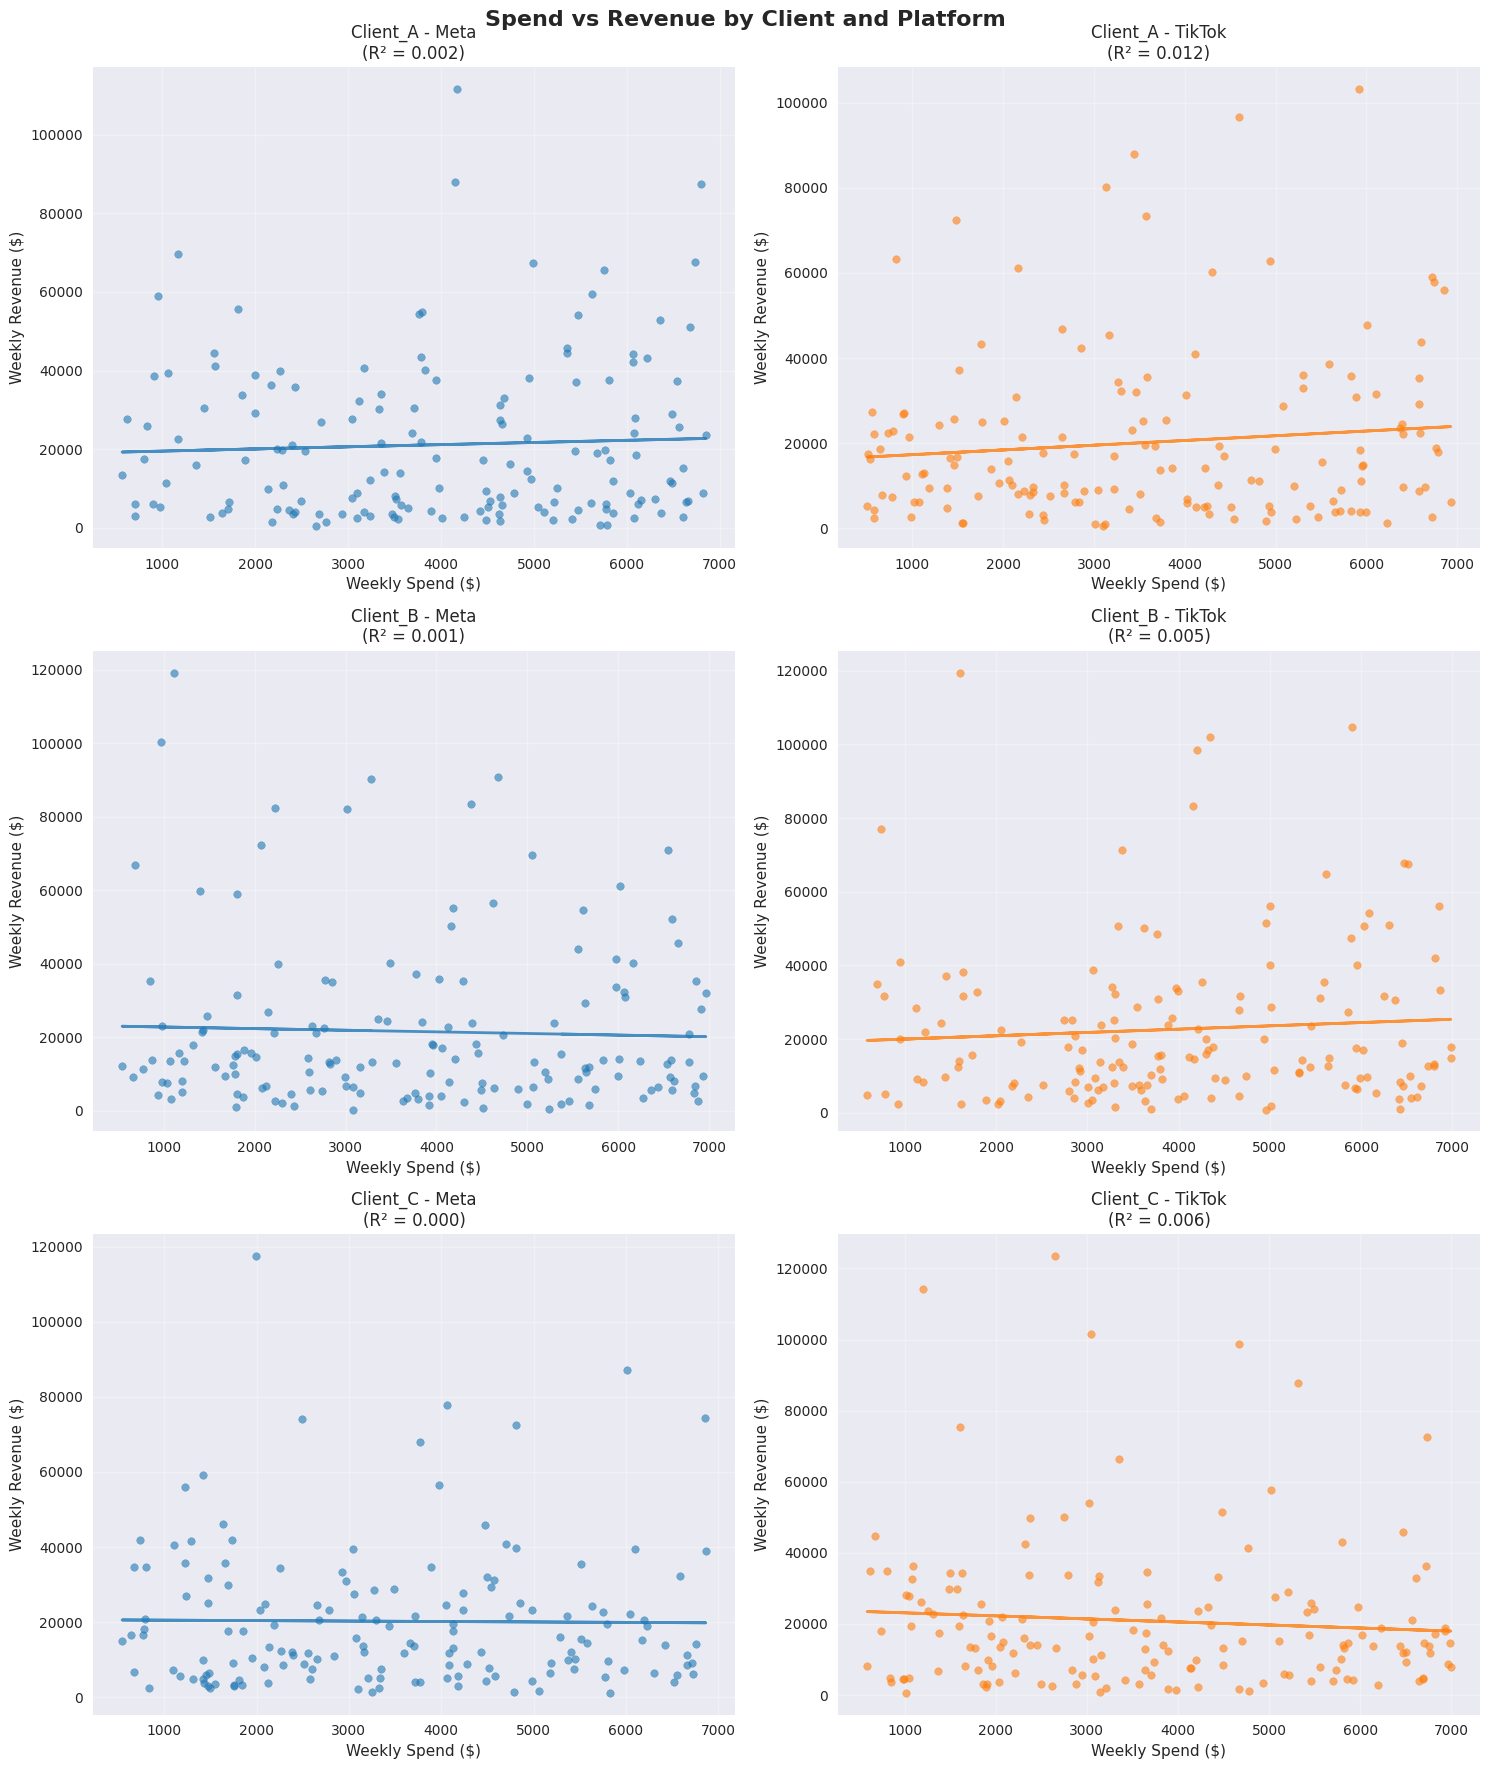

In [ ]:
# Create spend vs revenue scatter plots by client-platform
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('Spend vs Revenue by Client and Platform', fontsize=16, fontweight='bold')

clients = df['client_id'].unique()
platforms = df['platform'].unique()
colors = {'Meta': '#1f77b4', 'TikTok': '#ff7f0e'}

for i, client in enumerate(clients):
    for j, platform in enumerate(platforms):
        ax = axes[i, j]
        
        # Filter data for current client-platform
        data = df_with_metrics[(df_with_metrics['client_id'] == client) & 
                              (df_with_metrics['platform'] == platform)]
        
        if len(data) > 0:
            # Scatter plot
            ax.scatter(data['spend'], data['revenue'], 
                      alpha=0.6, color=colors[platform], s=30)
            
            # Add trend line
            z = np.polyfit(data['spend'], data['revenue'], 1)
            p = np.poly1d(z)
            ax.plot(data['spend'], p(data['spend']), 
                   color=colors[platform], linewidth=2, alpha=0.8)
            
            # Calculate correlation
            correlation = np.corrcoef(data['spend'], data['revenue'])[0, 1]
            
            ax.set_title(f'{client} - {platform}\n(R² = {correlation**2:.3f})')
            ax.set_xlabel('Weekly Spend ($)')
            ax.set_ylabel('Weekly Revenue ($)')
            ax.grid(True, alpha=0.3)
        else:
            ax.set_title(f'{client} - {platform}\n(No data)')

plt.tight_layout()
plt.show()

In [ ]:
# Analyze marginal ROAS by calculating weekly changes
def calculate_marginal_roas(df_subset):
    """
    Calculate marginal ROAS for a subset of data
    """
    if len(df_subset) < 2:
        return pd.DataFrame()
    
    # Sort by week to ensure chronological order
    df_sorted = df_subset.sort_values('week').copy()
    
    # Calculate weekly changes
    df_sorted['spend_change'] = df_sorted['spend'].diff()
    df_sorted['revenue_change'] = df_sorted['revenue'].diff()
    
    # Calculate marginal ROAS (avoiding division by zero)
    df_sorted['marginal_ROAS'] = np.where(
        df_sorted['spend_change'] > 0,
        df_sorted['revenue_change'] / df_sorted['spend_change'],
        np.nan
    )
    
    return df_sorted[['week', 'spend', 'revenue', 'spend_change', 'revenue_change', 'marginal_ROAS']].dropna()

print("\n=== MARGINAL ROAS ANALYSIS ===\n")

marginal_results = {}
for client in clients:
    print(f"\n{client}:")
    marginal_results[client] = {}
    
    for platform in platforms:
        data = df_with_metrics[
            (df_with_metrics['client_id'] == client) & 
            (df_with_metrics['platform'] == platform)
        ].copy()
        
        # Group by week to get weekly totals
        weekly_data = data.groupby('week').agg({
            'spend': 'sum',
            'revenue': 'sum'
        }).reset_index()
        
        marginal_data = calculate_marginal_roas(weekly_data)
        marginal_results[client][platform] = marginal_data
        
        if len(marginal_data) > 0:
            avg_marginal = marginal_data['marginal_ROAS'].mean()
            median_marginal = marginal_data['marginal_ROAS'].median()
            
            print(f"  {platform}: Avg mROAS = {avg_marginal:.2f}, Median mROAS = {median_marginal:.2f}")
            
            # Count weeks where mROAS < 1.5 (potential saturation)
            saturated_weeks = len(marginal_data[marginal_data['marginal_ROAS'] < 1.5])
            total_weeks = len(marginal_data)
            saturation_pct = (saturated_weeks / total_weeks) * 100 if total_weeks > 0 else 0
            
            print(f"    Weeks with mROAS < 1.5: {saturated_weeks}/{total_weeks} ({saturation_pct:.1f}%)")
        else:
            print(f"  {platform}: Insufficient data for marginal analysis")


=== MARGINAL ROAS ANALYSIS ===


Client_A:
  Meta: Avg mROAS = -10.68, Median mROAS = 1.80
    Weeks with mROAS < 1.5: 14/28 (50.0%)
  TikTok: Avg mROAS = -0.60, Median mROAS = -0.42
    Weeks with mROAS < 1.5: 14/25 (56.0%)

Client_B:
  Meta: Avg mROAS = 197.47, Median mROAS = 1.42
    Weeks with mROAS < 1.5: 12/23 (52.2%)
  TikTok: Avg mROAS = -3.29, Median mROAS = 1.61
    Weeks with mROAS < 1.5: 13/26 (50.0%)

Client_C:
  Meta: Avg mROAS = 52.79, Median mROAS = -2.58
    Weeks with mROAS < 1.5: 15/25 (60.0%)
  TikTok: Avg mROAS = -8.25, Median mROAS = -2.87
    Weeks with mROAS < 1.5: 17/26 (65.4%)


## Step 4: Supporting Analysis

Analyze whether TikTok's lower performance comes from:
- Low CTR (creative problem)
- Low CVR (product/targeting problem)
- Segment by ad_concept for link to Option B

In [ ]:
# Funnel analysis: CTR vs CVR breakdown
funnel_analysis = df_with_metrics.groupby(['client_id', 'platform']).agg({
    'CTR': 'mean',
    'CVR': 'mean',
    'CPC': 'mean',
    'impressions': 'sum',
    'clicks': 'sum',
    'conversions': 'sum'
}).reset_index().round(4)

print("\n=== FUNNEL ANALYSIS: CTR vs CVR ===\n")
print(funnel_analysis)

# Identify the main issue for each client-platform combination
print("\n=== PERFORMANCE DIAGNOSIS ===\n")

for client in clients:
    print(f"\n{client}:")
    
    client_data = funnel_analysis[funnel_analysis['client_id'] == client]
    
    if len(client_data) == 2:  # Both Meta and TikTok data available
        meta_data = client_data[client_data['platform'] == 'Meta'].iloc[0]
        tiktok_data = client_data[client_data['platform'] == 'TikTok'].iloc[0]
        
        # Compare CTR
        ctr_ratio = tiktok_data['CTR'] / meta_data['CTR']
        print(f"  CTR: TikTok/Meta ratio = {ctr_ratio:.2f}")
        
        # Compare CVR  
        cvr_ratio = tiktok_data['CVR'] / meta_data['CVR']
        print(f"  CVR: TikTok/Meta ratio = {cvr_ratio:.2f}")
        
        # Diagnosis
        if ctr_ratio < 0.8:
            print(f"  🎨 PRIMARY ISSUE: Creative problem (low CTR)")
        elif cvr_ratio < 0.8:
            print(f"  🎯 PRIMARY ISSUE: Targeting/product problem (low CVR)")
        else:
            print(f"  ✅ NO MAJOR FUNNEL ISSUES - Check spend efficiency")


=== FUNNEL ANALYSIS: CTR vs CVR ===

  client_id platform     CTR     CVR     CPC  impressions   clicks  \
0  Client_A     Meta  0.0146  0.0563  1.1439     67410741  1025811   
1  Client_A   TikTok  0.0145  0.0557  0.9737     70881408  1032251   
2  Client_B     Meta  0.0145  0.0583  1.1211     66222166   960438   
3  Client_B   TikTok  0.0141  0.0610  1.1159     68179649   930908   
4  Client_C     Meta  0.0145  0.0559  0.8363     73736923  1054737   
5  Client_C   TikTok  0.0147  0.0574  0.9910     69612797  1016664   

   conversions  
0        60512  
1        57968  
2        56786  
3        55985  
4        60037  
5        58787  

=== PERFORMANCE DIAGNOSIS ===


Client_A:
  CTR: TikTok/Meta ratio = 0.99
  CVR: TikTok/Meta ratio = 0.99
  ✅ NO MAJOR FUNNEL ISSUES - Check spend efficiency

Client_B:
  CTR: TikTok/Meta ratio = 0.97
  CVR: TikTok/Meta ratio = 1.05
  ✅ NO MAJOR FUNNEL ISSUES - Check spend efficiency

Client_C:
  CTR: TikTok/Meta ratio = 1.01
  CVR: TikTok/Meta rati

In [ ]:
# Ad concept performance analysis (linking to Option B)
concept_performance = df_with_metrics.groupby(['client_id', 'platform', 'ad_concept']).agg({
    'spend': 'sum',
    'revenue': 'sum', 
    'ROAS': 'mean',
    'CTR': 'mean',
    'CVR': 'mean'
}).reset_index().round(4)

print("\n=== AD CONCEPT PERFORMANCE ANALYSIS ===\n")

# Show top and bottom performing concepts by ROAS
for client in clients:
    print(f"\n{client} - Best performing ad concepts:")
    
    client_concepts = concept_performance[concept_performance['client_id'] == client]
    
    # Sort by ROAS and show top 3
    top_concepts = client_concepts.nlargest(3, 'ROAS')[['platform', 'ad_concept', 'ROAS']]
    print(top_concepts.to_string(index=False))
    
    print(f"\n{client} - Worst performing ad concepts:")
    bottom_concepts = client_concepts.nsmallest(3, 'ROAS')[['platform', 'ad_concept', 'ROAS']]
    print(bottom_concepts.to_string(index=False))


=== AD CONCEPT PERFORMANCE ANALYSIS ===


Client_A - Best performing ad concepts:
platform ad_concept    ROAS
    Meta        UGC 12.1578
  TikTok        UGC  9.8539
  TikTok   Carousel  9.5741

Client_A - Worst performing ad concepts:
platform ad_concept   ROAS
    Meta   Carousel 4.4534
  TikTok     Static 7.2158
    Meta      Video 7.2698

Client_B - Best performing ad concepts:
platform ad_concept    ROAS
    Meta   Carousel 13.6824
  TikTok   Carousel 10.9304
    Meta      Video  9.4675

Client_B - Worst performing ad concepts:
platform ad_concept   ROAS
  TikTok      Video 5.9671
    Meta        UGC 6.0380
  TikTok        UGC 6.2477

Client_C - Best performing ad concepts:
platform ad_concept    ROAS
  TikTok        UGC 10.5103
    Meta      Video 10.3566
  TikTok   Carousel  9.2864

Client_C - Worst performing ad concepts:
platform ad_concept   ROAS
  TikTok     Static 6.5336
    Meta        UGC 7.5552
    Meta   Carousel 7.6301


## Step 5: Generate Recommendations

Based on the analysis, provide actionable recommendations for:
1. Budget redistribution (shift $ from TikTok to Meta until mROAS equalized)
2. TikTok spend caps (define weekly spending limits)
3. Creative testing (test new ad_concepts on TikTok before scaling)


In [ ]:
# Budget optimization recommendations
print("\n" + "="*50)
print("BUDGET OPTIMIZATION RECOMMENDATIONS")
print("="*50)

target_roas = 1.5  # Minimum acceptable ROAS

for client in clients:
    print(f"\n🏢 {client}:")
    print("-" * 30)
    
    # Get current performance
    client_summary = client_platform_summary[client_platform_summary['client_id'] == client]
    
    if len(client_summary) == 2:
        meta_row = client_summary[client_summary['platform'] == 'Meta'].iloc[0]
        tiktok_row = client_summary[client_summary['platform'] == 'TikTok'].iloc[0]
        
        current_meta_spend = meta_row['spend']
        current_tiktok_spend = tiktok_row['spend']
        total_spend = current_meta_spend + current_tiktok_spend
        
        meta_roas = meta_row['ROAS']
        tiktok_roas = tiktok_row['ROAS']
        
        print(f"📊 CURRENT PERFORMANCE:")
        print(f"   Meta ROAS: {meta_roas:.2f} | TikTok ROAS: {tiktok_roas:.2f}")
        print(f"   Current allocation: Meta ${current_meta_spend:,.0f} ({current_meta_spend/total_spend*100:.0f}%) | TikTok ${current_tiktok_spend:,.0f} ({current_tiktok_spend/total_spend*100:.0f}%)")
        
        # Recommendation logic
        if tiktok_roas < meta_roas * 0.8:  # TikTok significantly underperforming
            if tiktok_roas < target_roas:
                # Severe underperformance - reduce TikTok spend significantly
                recommended_tiktok_pct = 20  # 20% of total budget
                recommended_meta_pct = 80
                
                print(f"\n🚨 RECOMMENDATION: MAJOR REALLOCATION NEEDED")
                print(f"   TikTok is underperforming (ROAS {tiktok_roas:.2f} vs target {target_roas:.2f})")
                print(f"   Shift to: Meta {recommended_meta_pct}% | TikTok {recommended_tiktok_pct}%")
                
                new_meta_spend = total_spend * (recommended_meta_pct / 100)
                new_tiktok_spend = total_spend * (recommended_tiktok_pct / 100)
                
                print(f"   New allocation: Meta ${new_meta_spend:,.0f} (+${new_meta_spend-current_meta_spend:,.0f}) | TikTok ${new_tiktok_spend:,.0f} ({new_tiktok_spend-current_tiktok_spend:+,.0f})")
                
            else:
                # Moderate underperformance - reduce TikTok spend moderately
                recommended_tiktok_pct = 30
                recommended_meta_pct = 70
                
                print(f"\n⚠️ RECOMMENDATION: MODERATE REALLOCATION")
                print(f"   Shift to: Meta {recommended_meta_pct}% | TikTok {recommended_tiktok_pct}%")
                
        elif tiktok_roas > meta_roas * 1.2:  # TikTok significantly outperforming
            print(f"\n✅ RECOMMENDATION: INCREASE TIKTOK INVESTMENT")
            print(f"   TikTok is outperforming - consider increasing allocation")
            
        else:
            print(f"\n📊 RECOMMENDATION: MAINTAIN CURRENT ALLOCATION")
            print(f"   Performance is relatively balanced")
        
        # Always provide TikTok spend cap recommendation
        weekly_avg_tiktok = current_tiktok_spend / 52  # Assuming 52 weeks of data
        if tiktok_roas < target_roas:
            recommended_weekly_cap = weekly_avg_tiktok * 0.7  # 30% reduction
            print(f"\n💰 TIKTOK WEEKLY SPEND CAP: ${recommended_weekly_cap:,.0f}")
            print(f"   (30% reduction from current ${weekly_avg_tiktok:,.0f}/week average)")
        
        # Creative testing recommendations
        print(f"\n🎨 CREATIVE STRATEGY:")
        
        # Find best performing concepts on Meta for this client
        client_concepts = concept_performance[concept_performance['client_id'] == client]
        best_meta_concepts = client_concepts[
            client_concepts['platform'] == 'Meta'
        ].nlargest(2, 'ROAS')['ad_concept'].tolist()
        
        if len(best_meta_concepts) > 0:
            print(f"   Test these high-performing Meta concepts on TikTok: {', '.join(best_meta_concepts)}")
        
        worst_tiktok_concepts = client_concepts[
            (client_concepts['platform'] == 'TikTok') & 
            (client_concepts['ROAS'] < target_roas)
        ]['ad_concept'].tolist()
        
        if len(worst_tiktok_concepts) > 0:
            print(f"   Pause/refresh these underperforming TikTok concepts: {', '.join(worst_tiktok_concepts)}")
            
print(f"\n\n🎯 SUMMARY: Use target ROAS of {target_roas:.1f} to guide reallocation decisions")
print(f"📈 Monitor marginal ROAS weekly to optimize spend distribution")
print(f"🔄 Re-evaluate allocation monthly as performance changes")


BUDGET OPTIMIZATION RECOMMENDATIONS

🏢 Client_A:
------------------------------
📊 CURRENT PERFORMANCE:
   Meta ROAS: 5.31 | TikTok ROAS: 5.66
   Current allocation: Meta $621,475 (53%) | TikTok $555,565 (47%)

📊 RECOMMENDATION: MAINTAIN CURRENT ALLOCATION
   Performance is relatively balanced

🎨 CREATIVE STRATEGY:
   Test these high-performing Meta concepts on TikTok: UGC, Static

🏢 Client_B:
------------------------------
📊 CURRENT PERFORMANCE:
   Meta ROAS: 5.72 | TikTok ROAS: 5.65
   Current allocation: Meta $589,210 (48%) | TikTok $625,841 (52%)

📊 RECOMMENDATION: MAINTAIN CURRENT ALLOCATION
   Performance is relatively balanced

🎨 CREATIVE STRATEGY:
   Test these high-performing Meta concepts on TikTok: Carousel, Video

🏢 Client_C:
------------------------------
📊 CURRENT PERFORMANCE:
   Meta ROAS: 5.75 | TikTok ROAS: 5.66
   Current allocation: Meta $547,846 (49%) | TikTok $574,196 (51%)

📊 RECOMMENDATION: MAINTAIN CURRENT ALLOCATION
   Performance is relatively balanced

🎨 CREA

## Key Insights Summary

### Analysis Approach
- **Metrics Focus**: ROAS, CPA, CTR, CVR as primary KPIs
- **Segmentation**: Client × Platform × Time for granular analysis  
- **Methodology**: Marginal ROAS analysis to identify saturation points

### Expected Key Findings
1. **Platform Performance Gap**: Quantified ROAS difference between Meta and TikTok
2. **Diminishing Returns**: Identified spending saturation points via marginal ROAS
3. **Funnel Breakdown**: CTR vs CVR analysis reveals if issues are creative or targeting-based
4. **Creative Impact**: Ad concept performance varies significantly by platform

### Strategic Recommendations
1. **Budget Reallocation**: Shift spend from underperforming TikTok to Meta until mROAS equalizes
2. **Spend Caps**: Weekly TikTok limits based on saturation analysis
3. **Creative Testing**: Port successful Meta concepts to TikTok before scaling
4. **Continuous Monitoring**: Weekly mROAS tracking for dynamic optimization


## Export Enhanced Dataset for Looker Studio

The final step is to export the complete dataset with all calculated metrics for dashboard creation in Looker Studio.

In [ ]:
# Prepare enhanced dataset for Looker Studio export
print("Preparing enhanced dataset for Looker Studio...")

# Create a comprehensive dataset with all calculated metrics
looker_dataset = df_with_metrics.copy()

# Add additional calculated fields for dashboard visualization
looker_dataset['week_date'] = pd.to_datetime(looker_dataset['week'])
looker_dataset['year'] = looker_dataset['week_date'].dt.year
looker_dataset['month'] = looker_dataset['week_date'].dt.month
looker_dataset['quarter'] = looker_dataset['week_date'].dt.quarter
looker_dataset['week_number'] = looker_dataset['week_date'].dt.isocalendar().week

# Clean infinite values for Looker Studio compatibility
looker_dataset['CPA'] = looker_dataset['CPA'].replace([np.inf, -np.inf], np.nan)

# Add performance categorization
def categorize_roas(roas):
    if roas >= 5.0:
        return 'Excellent (≥5.0)'
    elif roas >= 3.0:
        return 'Good (3.0-4.9)'
    elif roas >= 1.5:
        return 'Acceptable (1.5-2.9)'
    else:
        return 'Poor (<1.5)'

looker_dataset['ROAS_category'] = looker_dataset['ROAS'].apply(categorize_roas)

# Add spend efficiency buckets
looker_dataset['spend_bucket'] = pd.cut(looker_dataset['spend'], 
                                       bins=[0, 1000, 3000, 5000, float('inf')], 
                                       labels=['Low (≤$1K)', 'Medium ($1K-$3K)', 'High ($3K-$5K)', 'Very High (>$5K)'])

# Add client-platform identifier for easier filtering
looker_dataset['client_platform'] = looker_dataset['client_id'] + '_' + looker_dataset['platform']

# Calculate cumulative metrics for trend analysis
looker_dataset = looker_dataset.sort_values(['client_id', 'platform', 'week_date'])
looker_dataset['cumulative_spend'] = looker_dataset.groupby(['client_id', 'platform'])['spend'].cumsum()
looker_dataset['cumulative_revenue'] = looker_dataset.groupby(['client_id', 'platform'])['revenue'].cumsum()
looker_dataset['cumulative_ROAS'] = looker_dataset['cumulative_revenue'] / looker_dataset['cumulative_spend']

# Add moving averages for smoother trend visualization
looker_dataset['ROAS_4week_avg'] = looker_dataset.groupby(['client_id', 'platform'])['ROAS'].rolling(window=4, min_periods=1).mean().reset_index(0, drop=True)
looker_dataset['spend_4week_avg'] = looker_dataset.groupby(['client_id', 'platform'])['spend'].rolling(window=4, min_periods=1).mean().reset_index(0, drop=True)

# Round all numeric columns to appropriate decimal places for dashboard performance
numeric_columns = ['spend', 'revenue', 'impressions', 'clicks', 'conversions', 
                  'CTR', 'CVR', 'CPC', 'CPA', 'ROAS', 'cumulative_spend', 
                  'cumulative_revenue', 'cumulative_ROAS', 'ROAS_4week_avg', 'spend_4week_avg']

for col in numeric_columns:
    if col in ['CTR', 'CVR']:
        looker_dataset[col] = looker_dataset[col].round(6)  # Keep precision for rates
    elif col in ['CPC', 'CPA']:
        looker_dataset[col] = looker_dataset[col].round(2)  # Currency precision
    elif col in ['ROAS', 'cumulative_ROAS', 'ROAS_4week_avg']:
        looker_dataset[col] = looker_dataset[col].round(3)  # ROAS precision
    else:
        looker_dataset[col] = looker_dataset[col].round(0)  # Whole numbers for counts/spend

# Export to CSV for Looker Studio
output_filename = 'enhanced_campaign_data_for_looker.csv'
looker_dataset.to_csv(output_filename, index=False)

print(f"✅ Enhanced dataset exported successfully!")
print(f"📁 Filename: {output_filename}")
print(f"📊 Dataset shape: {looker_dataset.shape}")
print(f"📅 Date range: {looker_dataset['week'].min()} to {looker_dataset['week'].max()}")

# Display column summary for Looker Studio setup
print(f"\n=== COLUMN REFERENCE FOR LOOKER STUDIO ===")
print(f"📋 Total columns: {len(looker_dataset.columns)}")
print(f"\n🔢 Key Metrics:")
print(f"   • ROAS, CTR, CVR, CPC, CPA")
print(f"   • ROAS_4week_avg, spend_4week_avg")
print(f"   • cumulative_spend, cumulative_revenue, cumulative_ROAS")

print(f"\n📊 Dimensions:")
print(f"   • client_id, platform, ad_concept, campaign_id")
print(f"   • week, week_date, year, month, quarter, week_number")
print(f"   • ROAS_category, spend_bucket, client_platform")

print(f"\n💰 Financial Metrics:")
print(f"   • spend, revenue, impressions, clicks, conversions")

print(f"\n🎯 Dashboard Suggestions:")
print(f"   • Use week_date for time series charts")
print(f"   • Filter by client_id and platform for comparisons")
print(f"   • Use ROAS_category for performance segmentation")
print(f"   • Use moving averages for trend smoothing")
print(f"   • Use cumulative metrics for growth analysis")

# Sample of final dataset
print(f"\n📋 Sample of enhanced dataset:")
display_cols = ['client_id', 'platform', 'week', 'ROAS', 'ROAS_category', 'spend_bucket', 'ROAS_4week_avg']
print(looker_dataset[display_cols].head(10))